In [1]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import io
import torch
import numpy as np
from CONFIG import config
from datalib import build_data_loader, load_data
from datalib.transforms import ParameterCompose,RandomHorizontalFlip,RandomVerticalFlip
%load_ext autoreload
%autoreload 2

### Data Visualization

* Here, we investigate the transforms on train dataset. We compare the data in a sequence before and after the transformations being applied. 
* The transforms are implemented to equally to all the samples in a sequence, preserving the time consistanct of the video sequence.
* Each new sequence gets fresh random decisions for augmentation. This is done in MoviC.py file line 50 (self.transforms.reset_sequence(sequence_idx=idx), num_epochs=self.num_epochs) resets the flags for horizontal and vertical flips.
* For the sake of having the same transformation on all data in a sequence, we needed to have different seeds per sequence. But at the same time we need a base/stable seed during training the model and initializeing the tensors. To solve this problem, we considered the seed for training as `base_seed` which is increased by idx - the index of the sequence in the dataset - and also a random value in range(epoch). This ensures both consistancy during data augmentatin per sequence, diversity per sequence/epoch, and also during training procecss for tensors (having a defined base-seed).( This is done in _make_sequence_decisions() function line 35 in MoviC.py). Although this approach provides deterministicc results for agumentation `per_sequence`, is it non-deterministic `per run`!

* For each sequence, the choosen augmentation can be aither vertical, horizontal, both, or neither! This is also done in _make_sequence_decisions() function in MoviC.py. We consider independent probabilities for each augmentation:

    - should_hflip = random.random() < 0.3: 30% chance of horizontal flip.
    - should_vflip = random.random() < 0.7: 70% chance of vertical flip.

    Since these are independent, the possible outcomes per sequence are:

    - Neither: (1-0.3) * (1-0.7) = 70% * 30% = 21% probability.

    - Horizontal only: 30% * 30% = 9% probability.

    - Vertical only: 70% * 70% = 49% probability.

    - Both: 30% * 70% = 21% probability.

    

In [2]:

# Apply transforms to ENTIRE sequence using transform pipeline

path = config['data']['dataset_path']
train_dataset = load_data(path, split='train', use_transforms=False)
train_dataset_transformed = load_data(path, split='train', use_transforms=True)


[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737
[INFO] - TRAIN Data Loaded: Coordinates: 9737, Masks: 9737, RGB videos:  9737, Flows:  9737


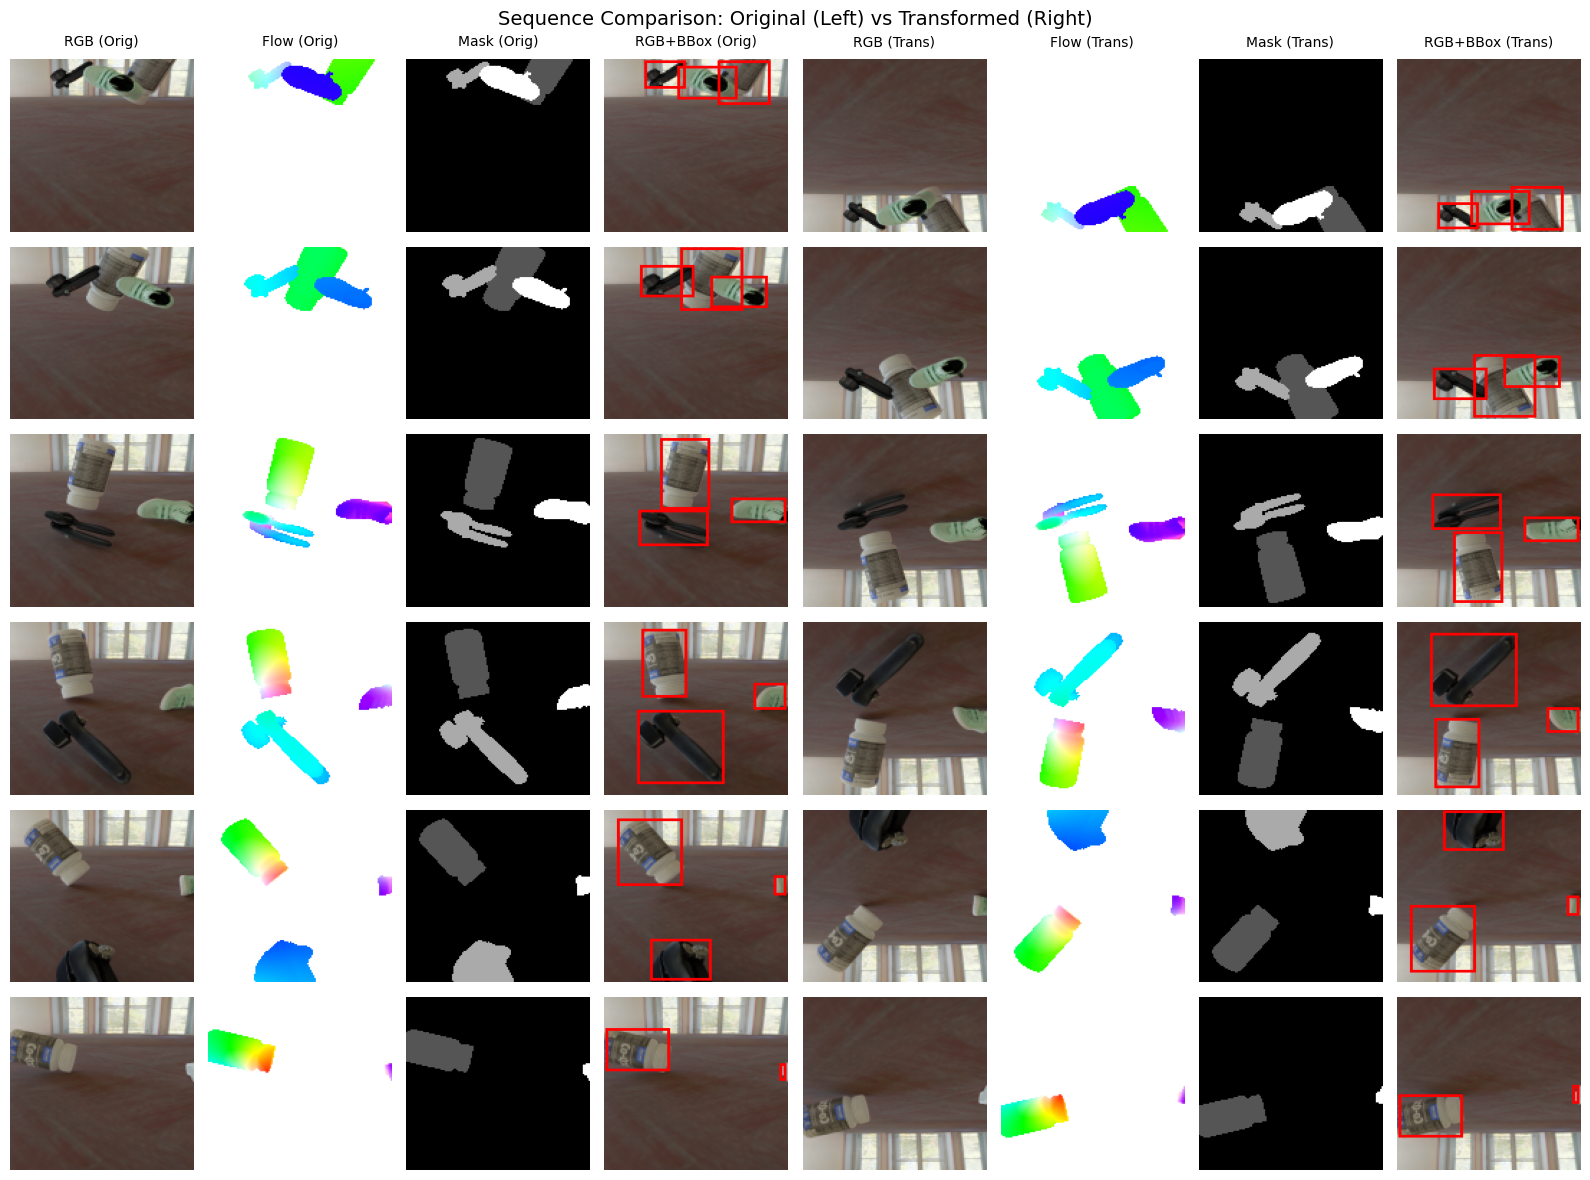

In [6]:
from utils.utils import plot_sequence_comparison


idx = np.random.randint(0, len(train_dataset))

rgbs_orig, masks_orig, flows_orig, coords_orig = train_dataset[idx]
rgbs_trans, masks_trans, flows_trans, coords_trans = train_dataset_transformed[idx]


plot_sequence_comparison(
                        rgbs_orig, masks_orig, flows_orig, coords_orig,
                        rgbs_trans, masks_trans, flows_trans, coords_trans,
                        n_rows=6, sequence_idx=idx
                        )

### Datalloaders and modality shapes

In [18]:
val_dataset = load_data(path, split='validation', use_transforms=True)

train_loader= build_data_loader(train_dataset, split='train')
val_loader = build_data_loader(val_dataset, split='validation')


[INFO] - VALIDATION Data Loaded: Coordinates: 250, Masks: 250, RGB videos:  250, Flows:  250


In [12]:
## Verifying the dataloader  
rgbs, masks, flows, coords = next(iter(val_loader))

print(f"RGBs shape: {rgbs.shape}\nFlows shape: {flows.shape}\nMasks shape: {masks['masks'].shape} \nCoords com shape: {coords['com'].shape}\nCoords bbxs shape: {coords['bbox'].shape}")


RGBs shape: torch.Size([64, 24, 3, 128, 128])
Flows shape: torch.Size([64, 24, 3, 128, 128])
Masks shape: torch.Size([64, 24, 128, 128]) 
Coords com shape: torch.Size([64, 24, 11, 2])
Coords bbxs shape: torch.Size([64, 24, 11, 4])


### Patchifier

Patchified Shape: torch.Size([64, 24, 16, 3072])
Number of patches: 16
Patch size: 32


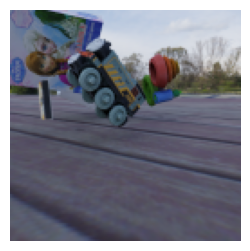

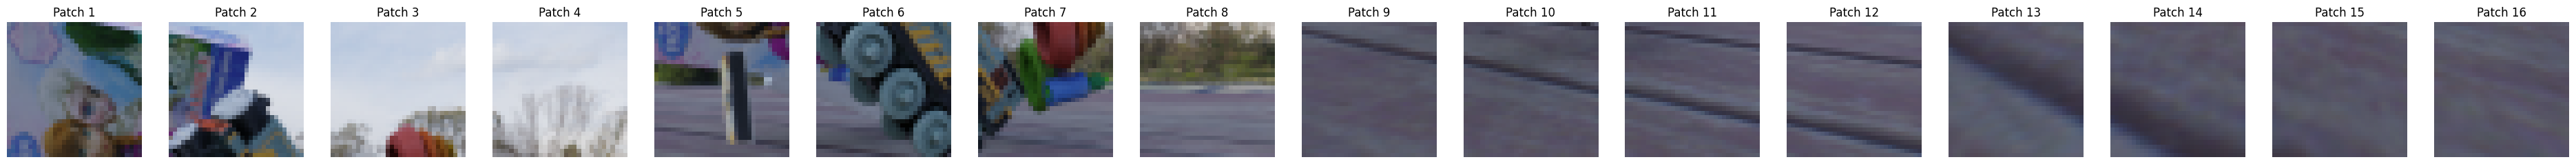

In [13]:
from model.model_utils import Patchifier

BATCH_IDX = 4
seq_len = 5
img = rgbs[BATCH_IDX, seq_len]
plt.figure(figsize=(3, 3))
plt.imshow(img.permute(1, 2, 0)/255.0)
# print(f"Image Shape: {img.shape}")
plt.axis("off")

patch_size = config['data']['patch_size'] # num of H and W pixels of each patch
patchifier = Patchifier(patch_size)
patch_data = patchifier(rgbs)
print(f"Patchified Shape: {patch_data.shape}") # (B, seq_len, num_patch_H * num_patch_W, 3 * 32 * 32)

num_patches = patch_data.shape[2] # num_patches = num_patch_H * num_patch_W
print(f"Number of patches: {num_patches}")
print(f"Patch size: {patch_size}")
fig, ax = plt.subplots(1, num_patches)
fig.set_size_inches(3 * num_patches, 3)
for i in range(num_patches):
    cur_patch = patch_data[BATCH_IDX, seq_len, i].reshape(3, patch_size, patch_size)
    ax[i].imshow(cur_patch.permute(1, 2, 0)/255.0)
    ax[i].set_title(f"Patch {i+1}")
    ax[i].axis("off")

plt.show()

### Masked Autoencoders

For the first phase of the project, we would be solving the image reconstruction task. For this purpose, we train a transformer based encoder-decoder. For the sake of image reconstruction, we would need to use the masked autoencoder archirecture as in the following image:

# <img src="../docs/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png" width="640" height="480">



In [14]:
from model.encoder import MultiModalVitEncoder

encoder = MultiModalVitEncoder()
                                # patch_size = patch_size, 
                                # embed_dim = 128, 
                                # attn_dim = 192, 
                                # num_heads = 4, 
                                # mlp_size = 1024, 
                                # encoder_depth = 4, 
                                # in_chans = 3, 
                                # max_len  = 64,
                                # mask_ratio = 0.75,
                                # max_objects=11,
                                # use_masks=False,
                                # use_bboxes=False,
                                # norm_pix_loss=False)

In [15]:
encoder

MultiModalVitEncoder(
  (encoder_pos_embed): PositionalEncoding()
  (patch_projection): Sequential(
    (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=128, out_features=192, bias=False)
        (k): Linear(in_features=128, out_features=192, bias=False)
        (v): Linear(in_features=128, out_features=192, bias=False)
        (out_proj): Linear(in_features=192, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    

In [16]:
x, mask, ids_restore = encoder(rgbs)
print("x shape:", x.shape)
print("mask shape:", mask['image'].shape)
print("ids_restore shape:", ids_restore['image'].shape)

x shape: torch.Size([64, 24, 4, 128])
mask shape: torch.Size([64, 24, 16])
ids_restore shape: torch.Size([64, 24, 16])


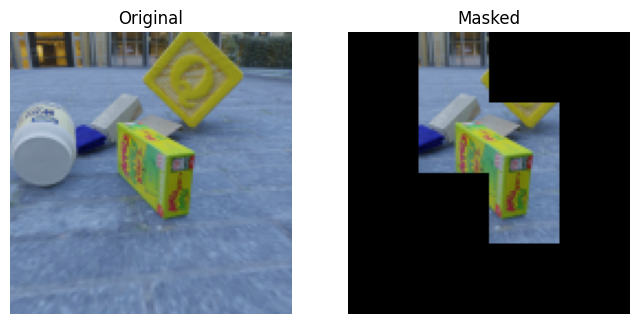

In [17]:
from utils.visualization import visualize_masked_image

sample_idx, frame_idx = 2, 9

img = rgbs[sample_idx, frame_idx]     # [3, 128, 128]
mask_frame = mask['image'][sample_idx, frame_idx]  # [N]

visualize_masked_image(img, mask_frame, patch_size=patch_size)


## Encoder


In [18]:
from model.encoder import MultiModalVitEncoder

encoder = MultiModalVitEncoder()
                                # patch_size = patch_size, 
                                # embed_dim = 128, 
                                # attn_dim = 192, 
                                # num_heads = 4, 
                                # mlp_size = 1024, 
                                # encoder_depth = 4, 
                                # in_chans = 3, 
                                # max_len  = 64,
                                # mask_ratio = 0.75,
                                # max_objects=11,
                                # use_masks=True,
                                # use_bboxes=False,
                                # norm_pix_loss=False)
                                
                                
encoder

MultiModalVitEncoder(
  (encoder_pos_embed): PositionalEncoding()
  (patch_projection): Sequential(
    (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=128, out_features=192, bias=False)
        (k): Linear(in_features=128, out_features=192, bias=False)
        (v): Linear(in_features=128, out_features=192, bias=False)
        (out_proj): Linear(in_features=192, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    

In [19]:
encoded_features, mask, ids_restore = encoder(rgbs, masks , coords['bbox'])
print("Features shape:\n", encoded_features.shape)
print(f'mask and restored_ids are now dict:', mask.keys())
print("Mask shape:\n images:", mask['image'].shape,f'mask_mask:', mask['mask'].shape, f'mask_bboxs:', mask['bbox'].shape)
print("ids_restore shape:\n images:", ids_restore['image'].shape,f'mask:', ids_restore['mask'].shape, f'bboxs:', ids_restore['bbox'].shape)

Features shape:
 torch.Size([64, 24, 12, 128])
mask and restored_ids are now dict: dict_keys(['image', 'mask', 'bbox'])
Mask shape:
 images: torch.Size([64, 24, 16]) mask_mask: torch.Size([64, 24, 16]) mask_bboxs: torch.Size([64, 24, 11])
ids_restore shape:
 images: torch.Size([64, 24, 16]) mask: torch.Size([64, 24, 16]) bboxs: torch.Size([64, 24, 11])


## Decoder

In [20]:
from model.decoder import VitDecoder

decoder = VitDecoder()
                        # patch_size = patch_size, 
                        # embed_dim = 128,
                        # decoder_embed_dim = 64,
                        # attn_dim=192, 
                        # num_heads =4, 
                        # mlp_size = 512, 
                        # decoder_depth = 2, 
                        # out_chans = 3, 
                        # max_len = 64,
                        # norm_pix_loss=False
                    # )

decoder


VitDecoder(
  (encoder_pos_embed): PositionalEncoding()
  (patch_projection): Sequential(
    (0): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (encoder_blocks): Sequential(
    (0): TransformerBlock(
      (ln_att): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (q): Linear(in_features=128, out_features=192, bias=False)
        (k): Linear(in_features=128, out_features=192, bias=False)
        (v): Linear(in_features=128, out_features=192, bias=False)
        (out_proj): Linear(in_features=192, out_features=128, bias=False)
      )
      (ln_mlp): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
    )
    (1): Trans

In [21]:
recons, loss = decoder(encoded_features,mask['image'], ids_restore['image'])


In [22]:
recons.shape

torch.Size([64, 24, 3, 128, 128])

### Holistic scene representation

In [21]:
from model.ocvp import TransformerAutoEncoder, TransformerPredictor, OCVP
from model.decoder import VitDecoder
from model.predictor import Predictor
from model.holistic_encoder import HolisticEncoder
from model.oc_encoder import ObjectCentricEncoder
from utils.utils import count_model_params

In [22]:
holistic_encoder = HolisticEncoder(mode='training', mask_ratio=0.75)

holistic_decoder = VitDecoder(mode='training')

model = TransformerAutoEncoder(holistic_encoder, holistic_decoder)

print(count_model_params(model))
# model

2196096


In [19]:
rgbs, masks, flows, coords = next(iter(val_loader))

In [23]:
encoded_features, image_mask, image_ids_restore = holistic_encoder(rgbs, masks, coords)
encoded_features.shape

torch.Size([64, 24, 4, 128])

In [26]:
recons, loss = holistic_decoder(encoded_features, image_mask, image_ids_restore)
recons.shape

torch.Size([64, 24, 3, 128, 128])

In [ ]:
recons, loss = model(rgbs, masks, coords)
recons.shape

torch.Size([64, 24, 3, 128, 128])

In [30]:
loss

tensor(0.3087, grad_fn=<DivBackward0>)